# Simple 3D Finite Plasticity model



In [1]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log,default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem,LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split,TestFunction,indices,as_tensor)
from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime
from dolfinx.plot import vtk_mesh
from dolfinx.fem.petsc import  assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc,create_matrix, create_vector
import basix
import pyvista
pyvista.set_jupyter_backend('client')
## Define temporal parameters

## Some parameters

In [2]:
# Geometric parameters
geom = {"longside" : 100.0,     # mm
        "side" : 10.0,      # mm
        "num_elements" : 3,    # size of a cell
        }


# Mechanicals parameters
mech = {"E" : 200e3,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 250.,  # MPa
        "H" : 707., # MPa
        }


# Study parameters
stud = {"deg u" : 2,    # Interpolation of u
        "deg sig" : 2,  # Interpolation of sig, eps, p
        "N incr" : 50,  # Number of load steps
        "Max Disp" : 1 # Maximal displacement
        }


# Define Geometry

In [3]:

domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0.0],[geom["longside"],geom["side"],geom["side"]]],[geom["num_elements"]*10,geom["num_elements"],geom["num_elements"]])

In [4]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:36803/index.html?ui=P_0xffff653e7ca0_0&reconnect=auto' style='widt…

## Material Parameters

In [5]:
E = Constant(domain, mech["E"])
nu = Constant(domain, mech["nu"])
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2.0 / (1 + nu)
sig0 = Constant(domain, mech["sig0"])  # yield strength
H = Constant(domain,mech["H"])  # hardening modulus

## Defining Boundary

In [6]:
def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], geom["longside"])
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], geom["side"])
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], geom["side"])

In [7]:
boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])


# Defining Function Spaces

In [8]:
deg_u = stud["deg u"]
deg_stress = stud["deg sig"]
Ve = element(
    "Lagrange", domain.basix_cell(), deg_u, shape=(3,)
)  # 2 degrees  of freedom
V = functionspace(domain, Ve)

Ve_scal = element(
    "Lagrange", domain.basix_cell(), deg_u
)
V_scal = functionspace(domain, Ve_scal)

We = quadrature_element(domain.basix_cell(), value_shape=(6,), degree=deg_stress,scheme='default')
W = functionspace(domain, We)

W_scal_e = quadrature_element(domain.basix_cell(), degree=deg_stress,scheme='default')
W_scal = functionspace(domain, W_scal_e)

In [9]:
T = Function(W,name = "Stress")
E_p = Function(W, name="Total_Plastic_Strain")
e_p= Function(W_scal, name="Equivalent_Plastic_Strain")
u = Function(V, name="Total_displacement")
du = Function(V, name="Trial_displacement")

dp = Function(W_scal,name="Delta_plasticity")



v = TestFunction(V) #Function we are testing with
du_ = TrialFunction(V) #Function we are solving for

e_p_ = TrialFunction(W_scal)
e_pv = TestFunction(W_scal)


dx = ufl.Measure("dx",domain=domain,  metadata={"quadrature_degree": deg_u, "quadrature_scheme": "default"} )
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': deg_u})

n = ufl.FacetNormal(domain)

# Boundary Conditions

In [10]:
left_facets = facet_tag.find(1)
right_facets = facet_tag.find(2)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, domain.topology.dim)
disp = Constant(domain,0.0)

left_dofs_x = fem.locate_dofs_topological(V, fdim, left_facets)
right_dofs_x = fem.locate_dofs_topological(V.sub(0),fdim, right_facets)

sym_bottom = fem.dirichletbc(np.array((0.0,0.0,0.0)), left_dofs_x, V)
sym_left = fem.dirichletbc(disp, right_dofs_x, V.sub(0))

bcs = [sym_bottom, sym_left]



def F_ext(t):
    return t*stud["Max Disp"]

# Constitive Relations

In [11]:
from ufl.tensors import ComponentTensor


def eps(v: Function) -> ComponentTensor:
    """
    Generates a  strain tensor from input of a 3D displacement vector.


    Parameters:
    -----------
        u (2d Vector Funciton): 3D displacement vector.

    Returns:
    --------
        3x3 Tensor: Plain strain tensor generated from the displacement vector.
    """
    e = ufl.sym(grad(v))
    return e # Plain strain tensor


def sigma_tr(eps_el):
    """
    Generates the stress tensor from the input of a plain strain tensor.

    Parameters:
    ----------
        eps_el (numpy.ndarray): Plain strain tensor.

    Returns:
    --------
        3x3 Tensor: the trace of the plain stress tensor
    """
    return 1./3. * (3. * lmbda + 2. * mu) * ufl.tr(eps_el) * ufl.Identity(3)


def sigma_dev(eps_el):
    """
    Generates the stress tensor from the input of a plain strain tensor.

    Parameters:
    ----------
        eps_el (numpy.ndarray): Plain strain tensor.

    Returns:
    --------
        3x3 Tensor: The deviatoric part of the stress tensor.
    """
    return 2. * mu * ufl.dev(eps_el)


def as_3D_tensor(X):
    """Converts an array to a 3D tensor.

    Parameters:
    ----------
       X (Function): Array to be converted to 3D tensor.

    Returns:
    --------
        3x3 Tensor: 3D tensor generated from the input array.
    """
    return ufl.as_tensor([[X[0], X[3], X[4]],
                      [X[3], X[1], X[5]],
                      [X[4], X[5], X[2]]])

def tensor_to_vector(X): 
    ''' 
    Take a 3x3 tensor and return a vector of size 4 in 2D
    '''
    return ufl.as_vector([X[0, 0], X[1, 1], X[2, 2], X[0, 1], X[0, 2], X[1, 2]])


def sigma(eps_el: Function) -> ComponentTensor:
    
    return lmbda * tr(eps_el) * Identity(3) + 2 * mu * eps_el


In [12]:
def normVM(sig): # Von Mises equivalent stress
    s_ = ufl.dev(sig)
    return ufl.sqrt(3 / 2. * ufl.inner(s_, s_))

In [13]:
#This is the plastic stress function (For now we'll just assume regular strain hardening)
def Y(e_p):
    return sig0  + H * e_p

In [14]:
E_n = eps(u)
del_E_n = eps(du_)
E_p_tensor = as_3D_tensor(E_p)
E_e_trial = E_n - E_p_tensor + del_E_n #Trial Elastic Strain

T_trial = sigma(E_e_trial) #Trial cauchy stress
#bilinear Part to solve for du Incrementally
#This is the linear part (In total this will be 0)
F_body = Constant(domain,np.array((0.0,0.0,0.0)))

F = ufl.inner(T_trial,eps(v))*dx - ufl.inner(F_body, v) * dx 

a_du, L_du = ufl.lhs(F), ufl.rhs(F)

In [15]:

del_E = eps(du)
E_e_trial_plastic = E_n - E_p_tensor + del_E #Trial Elastic Strain for plastic step
T_trial_p = sigma(E_e_trial_plastic)

sigma_vm_trial = normVM(T_trial_p) #Trial Von Mises Stress

N_p = dev(T_trial_p)/sigma_vm_trial

f_trial = sigma_vm_trial - Y(e_p) #Trial Yield Function


Phi = sigma_vm_trial - 3*mu*dp -Y(e_p+dp)
Phi_cond = conditional(gt(f_trial, 0) , Phi, dp) #Plastic multiplier

res_p = inner(Phi_cond,e_pv)*dx


Jacobian = derivative(res_p,dp,e_p_)

In [16]:

problem = NonlinearProblem(res_p, dp, [], Jacobian)
nls_solver = NewtonSolver(MPI.COMM_WORLD, problem)
nls_solver.convergence_criterion = "incremental"
nls_solver.rtol = 1e-8
nls_solver.atol = 1e-8
nls_solver.max_it = 50
nls_solver.report = True
nls_solver.relaxation_parameter = 1



ksp = nls_solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
#opts[f"{option_prefix}pc_factor_mat_solver_type"] = "superlu_dist"
opts[f"{option_prefix}ksp_max_it"] = 50
ksp.setFromOptions()

In [17]:
def project(v, target_func, bcs=[]):
    """Project UFL expression.

    Note
    ----
    This method solves a linear system (using KSP defaults).

    """

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    dx = ufl.dx(V.mesh)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = dolfinx.fem.form(ufl.inner(Pv, w) * dx)
    L = dolfinx.fem.form(ufl.inner(v, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_func.vector)

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()

In [18]:
def solve_plastic():
    # Solve DP

    nls_solver.solve(dp)
    # Do updates
    e_p_exp = Expression(e_p+dp,W_scal.element.interpolation_points())
    e_p.interpolate(e_p_exp)
    
    E_p_expr = Expression(E_p+tensor_to_vector(N_p*dp*sqrt(3/2)),W.element.interpolation_points())
    
    E_p.interpolate(E_p_expr)

In [19]:
def interpolate_quadrature(ufl_expr, fem_func:fem.Function):
    q_dim = fem_func.function_space._ufl_element.degree
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = mesh.basix_cell()
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(mesh,cells)
    fem_func.x.array[:] = expr_eval.flatten()

In [20]:

a = fem.form(a_du)
L = fem.form(L_du)
A = assemble_matrix(a, bcs=bcs)
A.assemble()
b = create_vector(L)
assemble_vector(b, L)
apply_lifting(b, [a], [bcs],[u.vector], scale=1)
set_bc(b, bcs,u.vector)


Stress_Point = sigma(E_n - E_p_tensor)
area= Constant(domain,(geom["side"]*geom["side"]))

Elastic = Function(V_scal)
project(Stress_Point[0,0],Elastic)
engineeringStress= fem.form(Elastic/area*ds(2)) #P22/area*ds

In [21]:
pointForStress = [geom["longside"],0,0]

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))

In [22]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

def solve_linear():
    with b.localForm() as loc_L:
            loc_L.set(0)
    A.zeroEntries()
    assemble_matrix(A,a, bcs=bcs)
    A.assemble()
    assemble_vector(b, L)
    
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    apply_lifting(b, [a], [bcs],[ u.vector], scale=1)

    set_bc(b, bcs,u.vector)
    
    res2val = solver.solve(b, du.vector)



In [23]:
du.x.array

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
tes= Function(W_scal)
tes_exp = Expression(Phi,W_scal.element.interpolation_points())
tes.interpolate(tes_exp)
tes.x.array

array([-250., -250., -250., ..., -250., -250., -250.])

In [25]:
startTime = datetime.now()
Nincr = stud["N incr"]

load_steps = np.linspace(0, .03, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")


log.set_log_level(log.LogLevel.INFO)

for (i, t) in enumerate(load_steps):
    # Update Diriclet boundary condition
    du.x.array[:] = 0.0
    dp.x.array[:] = 0.0
    disp.value = F_ext(t)
    # Update the right hand side reusing the initial vector

    nRes0 = b.norm()
    nRes = nRes0
    print("Increment:", str(i+1))
    niter = 0
    print("Linear Step 1 Start")
    solve_linear() #Solves for the first trial displacement
    print("Linear Step 1 Done")
    print("Starting Plastic Step")
    solve_plastic()
    print("Stop Plastic Step  Done")
    print("Linear Step 2 Start")
    solve_linear() #Solves for the actual displacement after the plastic update
    print("Linear Step 1 Done")
    
    
    u.x.array[:] += du.x.array[:]
    
    
    project(Stress_Point[0,0],Elastic)
    u_pointe = u.eval(pointForStress,colliding_cells.array[0])[0]
    stress =  domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    results[i + 1, :] = (u_pointe,stress)
    

print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")    
    

------------------------------------
Simulation Start
------------------------------------
Increment: 1
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:09.157 (   2.842s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:09.158 (   2.843s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:09.159 (   2.844s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:09.159 (   2.844s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 2
Linear Step 1 Start


2023-12-09 16:55:09.384 (   3.069s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:09.606 (   3.291s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:09.608 (   3.292s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:09.608 (   3.293s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:09.608 (   3.293s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 3
Linear Step 1 Start


2023-12-09 16:55:09.836 (   3.520s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:10.066 (   3.750s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:10.067 (   3.752s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:10.068 (   3.753s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:10.068 (   3.753s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 4
Linear Step 1 Start


2023-12-09 16:55:10.291 (   3.975s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:10.515 (   4.199s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:10.516 (   4.201s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:10.517 (   4.201s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:10.517 (   4.201s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 5
Linear Step 1 Start


2023-12-09 16:55:10.736 (   4.421s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:10.956 (   4.640s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:10.957 (   4.642s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:10.958 (   4.642s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:10.958 (   4.642s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 6
Linear Step 1 Start


2023-12-09 16:55:11.188 (   4.873s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:11.413 (   5.097s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:11.414 (   5.099s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:11.415 (   5.100s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:11.415 (   5.100s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 7
Linear Step 1 Start


2023-12-09 16:55:11.634 (   5.319s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:11.851 (   5.536s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:11.852 (   5.537s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:11.853 (   5.538s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:11.853 (   5.538s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 8
Linear Step 1 Start


2023-12-09 16:55:12.081 (   5.766s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:12.308 (   5.992s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:12.309 (   5.994s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:12.310 (   5.995s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:12.310 (   5.995s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 9
Linear Step 1 Start


2023-12-09 16:55:12.532 (   6.217s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:12.753 (   6.437s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:12.754 (   6.439s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:12.755 (   6.440s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:12.755 (   6.440s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 10
Linear Step 1 Start


2023-12-09 16:55:12.985 (   6.670s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:13.206 (   6.890s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:13.207 (   6.892s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:13.208 (   6.893s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:13.208 (   6.893s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done


2023-12-09 16:55:13.441 (   7.125s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Increment: 11
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:13.661 (   7.346s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:13.663 (   7.347s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:13.664 (   7.348s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:13.664 (   7.348s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 12
Linear Step 1 Start


2023-12-09 16:55:13.892 (   7.577s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:14.129 (   7.814s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:14.131 (   7.815s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:14.131 (   7.816s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:14.131 (   7.816s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 13
Linear Step 1 Start


2023-12-09 16:55:14.362 (   8.047s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:14.592 (   8.277s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:14.594 (   8.278s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:14.594 (   8.279s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:14.594 (   8.279s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 14
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 16:55:14.824 (   8.509s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:15.073 (   8.758s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:15.075 (   8.760s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:15.076 (   8.760s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:15.076 (   8.760s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 15
Linear Step 1 Start


2023-12-09 16:55:15.300 (   8.985s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:15.528 (   9.213s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:15.529 (   9.214s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:15.530 (   9.215s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:15.530 (   9.215s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 16
Linear Step 1 Start


2023-12-09 16:55:15.762 (   9.446s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:15.986 (   9.670s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:15.987 (   9.672s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:15.988 (   9.673s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:15.988 (   9.673s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 17
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:16.211 (   9.896s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:16.428 (  10.113s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:16.430 (  10.114s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:16.430 (  10.115s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:16.430 (  10.115s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 18
Linear Step 1 Start


2023-12-09 16:55:16.655 (  10.339s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:16.883 (  10.568s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:16.885 (  10.570s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:16.886 (  10.570s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:16.886 (  10.571s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 19
Linear Step 1 Start


2023-12-09 16:55:17.110 (  10.795s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:17.333 (  11.017s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:17.334 (  11.019s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:17.335 (  11.019s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:17.335 (  11.019s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 20
Linear Step 1 Start


2023-12-09 16:55:17.558 (  11.242s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:17.778 (  11.462s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:17.779 (  11.464s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:17.780 (  11.465s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = nan(tol = 1e-08)
2023-12-09 16:55:17.780 (  11.465s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 21
Linear Step 1 Start


2023-12-09 16:55:18.016 (  11.700s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:18.243 (  11.927s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:18.244 (  11.929s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:18.245 (  11.930s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:18.245 (  11.930s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 22
Linear Step 1 Start


2023-12-09 16:55:18.465 (  12.150s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:18.689 (  12.373s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:18.690 (  12.375s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:18.691 (  12.376s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:18.691 (  12.376s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 23
Linear Step 1 Start


2023-12-09 16:55:18.919 (  12.604s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:19.140 (  12.825s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:19.142 (  12.826s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:19.142 (  12.827s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:19.142 (  12.827s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 24
Linear Step 1 Start


2023-12-09 16:55:19.363 (  13.047s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:19.584 (  13.268s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:19.585 (  13.270s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:19.586 (  13.271s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:19.586 (  13.271s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 25
Linear Step 1 Start


2023-12-09 16:55:19.817 (  13.502s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:20.038 (  13.723s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:20.039 (  13.724s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:20.040 (  13.725s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:20.040 (  13.725s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 26
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 16:55:20.260 (  13.944s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:20.484 (  14.169s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:20.486 (  14.171s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:20.487 (  14.171s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:20.487 (  14.171s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 27
Linear Step 1 Start


2023-12-09 16:55:20.710 (  14.395s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:20.935 (  14.620s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:20.937 (  14.622s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:20.938 (  14.623s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:20.938 (  14.623s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 28
Linear Step 1 Start


2023-12-09 16:55:21.182 (  14.867s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:21.400 (  15.085s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:21.402 (  15.087s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:21.403 (  15.087s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:21.403 (  15.087s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 29
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 16:55:21.631 (  15.315s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:21.858 (  15.543s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:21.860 (  15.545s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:21.861 (  15.545s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:21.861 (  15.545s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 30
Linear Step 1 Start


2023-12-09 16:55:22.090 (  15.774s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:22.325 (  16.009s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:22.326 (  16.011s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:22.327 (  16.012s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:22.327 (  16.012s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 31
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 16:55:22.560 (  16.244s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:22.789 (  16.473s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:22.790 (  16.475s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:22.791 (  16.476s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:22.791 (  16.476s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 32
Linear Step 1 Start


2023-12-09 16:55:23.014 (  16.699s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:23.247 (  16.932s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:23.249 (  16.934s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:23.250 (  16.934s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:23.250 (  16.934s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 33
Linear Step 1 Start


2023-12-09 16:55:23.474 (  17.159s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:23.704 (  17.389s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:23.706 (  17.391s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:23.707 (  17.392s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:23.707 (  17.392s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 34
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 16:55:23.937 (  17.622s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:24.168 (  17.853s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:24.170 (  17.855s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:24.171 (  17.855s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:24.171 (  17.855s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 35
Linear Step 1 Start


2023-12-09 16:55:24.396 (  18.081s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:24.623 (  18.307s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:24.624 (  18.309s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:24.625 (  18.310s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:24.625 (  18.310s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 36
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:24.874 (  18.559s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:25.098 (  18.783s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:25.100 (  18.785s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:25.101 (  18.785s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:25.101 (  18.785s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 37
Linear Step 1 Start


2023-12-09 16:55:25.319 (  19.004s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:25.540 (  19.225s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:25.542 (  19.226s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:25.543 (  19.227s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:25.543 (  19.227s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 38
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:25.767 (  19.451s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:25.993 (  19.678s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:25.995 (  19.679s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:25.995 (  19.680s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:25.995 (  19.680s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 39
Linear Step 1 Start


2023-12-09 16:55:26.224 (  19.908s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:26.443 (  20.128s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:26.445 (  20.130s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:26.446 (  20.130s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:26.446 (  20.130s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done


2023-12-09 16:55:26.665 (  20.350s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:26.880 (  20.565s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:26.882 (  20.566s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:26.882 (  20.567s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:26.882 (  20.567s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Increment: 40
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 41
Linear Step 1 Start


2023-12-09 16:55:27.098 (  20.783s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:27.314 (  20.998s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:27.315 (  21.000s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:27.316 (  21.000s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:27.316 (  21.000s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 42
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 16:55:27.532 (  21.217s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:27.746 (  21.431s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:27.748 (  21.432s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:27.748 (  21.433s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:27.748 (  21.433s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 43
Linear Step 1 Start


2023-12-09 16:55:27.965 (  21.649s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:28.180 (  21.864s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:28.181 (  21.866s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:28.182 (  21.866s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:28.182 (  21.866s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 44
Linear Step 1 Start


2023-12-09 16:55:28.400 (  22.084s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:28.615 (  22.299s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:28.616 (  22.301s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:28.617 (  22.302s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:28.617 (  22.302s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 45
Linear Step 1 Start


2023-12-09 16:55:28.834 (  22.519s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:29.049 (  22.734s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:29.051 (  22.735s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:29.051 (  22.736s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:29.051 (  22.736s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 46
Linear Step 1 Start


2023-12-09 16:55:29.271 (  22.955s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:29.495 (  23.179s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:29.497 (  23.181s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:29.498 (  23.182s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:29.498 (  23.182s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 47
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start


2023-12-09 16:55:29.730 (  23.415s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:29.958 (  23.643s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:29.960 (  23.645s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:29.961 (  23.646s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:29.961 (  23.646s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Increment: 48
Linear Step 1 Start
Linear Step 1 Done
Starting Plastic Step


2023-12-09 16:55:30.189 (  23.874s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:30.416 (  24.100s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:30.417 (  24.102s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:30.418 (  24.102s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:30.418 (  24.102s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 49
Linear Step 1 Start


2023-12-09 16:55:30.648 (  24.333s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:30.884 (  24.569s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:30.885 (  24.570s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:30.886 (  24.571s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:30.886 (  24.571s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
Increment: 50
Linear Step 1 Start


2023-12-09 16:55:31.116 (  24.801s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-09 16:55:31.346 (  25.031s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:31.348 (  25.032s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-09 16:55:31.349 (  25.034s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0 (tol = 1e-08) r (rel) = 0(tol = 1e-08)
2023-12-09 16:55:31.349 (  25.034s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Linear Step 1 Done
Starting Plastic Step
Stop Plastic Step  Done
Linear Step 2 Start
Linear Step 1 Done
-----------------------------------------
End computation
------------------------------------------
Elapsed real time:  0:00:22.735213
------------------------------------------


2023-12-09 16:55:31.584 (  25.268s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


In [26]:
res = fem.form(res_p)

V = fem.assemble_vector(res)
V.norm()

89.14768068663483

In [27]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(V_scal)
grid = pyvista.UnstructuredGrid(*vtkdata)
#grid["mag"]=np.log10(V.array)

actor = plotter.add_mesh(grid, show_edges=True)

plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:36803/index.html?ui=P_0xffff64c74040_0&reconnect=auto' style='widt…

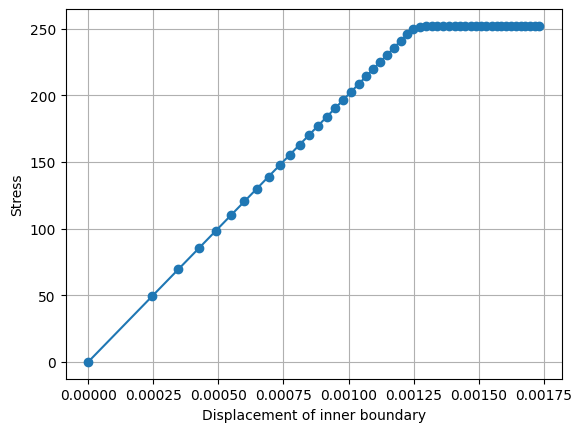

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('709616f160481bcaa58a9ae84fda237b_1140d')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "/root/2.077-Fenicsx-Plasticity/.venv/lib/python3.10/site-packages/wslink/protocol.py", line 332, in onMessage
    results = func(*args, **kwargs)
  File "/root/2.077-Fenicsx-Plasticity/.venv/lib/python3.10/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/root/2.077-Fenicsx-Plasticity/.venv/lib/python3.10/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 30, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
KeyError: '709616f160481bcaa58a9ae84fda237b_1140d'

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('67428f120937b51098439fd073b44a8d_3024L')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "/root/2.077-Fenicsx-Plast

In [29]:
import matplotlib.pyplot as plt
plt.plot(results[:, 0]/geom["longside"], results[:, 1], "-o")
plt.xlabel("Displacement of inner boundary")
plt.ylabel(r"Stress")
plt.grid()
plt.show()